In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import os
import pandas as pd

In [50]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [51]:
np.random.seed(42)

In [52]:
def add_noise(df, noise_level=0.0001):
    noisy_df = df.copy()
    for column in df.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level * df[column].std(), df[column].shape)
        noisy_df[column] += noise
    return noisy_df

In [53]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
# Iterate through the ASD and TD folders
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    # Iterate through files in each folder
    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            # Check if the corresponding bands file exists
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                combined_df = add_noise(combined_df)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)

In [54]:
# folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# data_list = []
# labels = []
# # Iterate through the ASD and TD folders
# for label, folder_name in enumerate(["ASD", "TD"]):
#     folder_dir = os.path.join(folder_path, folder_name)

#     # Iterate through files in each folder
#     for file_name in os.listdir(folder_dir):
#         if file_name.endswith(".xlsx"):
#             file_path = os.path.join(folder_dir, file_name)
#             # Check if the corresponding bands file exists
#             bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
#             if os.path.exists(bands_file_path):
#                 # Read both excel files
#                 df_main = pd.read_excel(file_path)
#                 df_bands = pd.read_excel(bands_file_path)
#                 # Combine along columns
#                 combined_df = pd.concat([df_main, df_bands], axis=1)
#                 # Append the combined data and label to the list
#                 data_list.append(combined_df)
#                 labels.append(label)

In [55]:
labels = np.array(labels)

In [56]:
data_list = np.array(data_list)

In [57]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [58]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data, labels, target_samples=1000, noise_factor=5)

In [59]:
def AutoEncoder(n_features):

    timesteps = 100
    # n_features = 11
    encoding_dim = 10  # Adjust encoding dimensions as needed

    inputs = Input(shape=(timesteps, n_features))

    # Encoder
    encoded = LSTM(128, return_sequences=True)(inputs)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(64, return_sequences=True)(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(encoding_dim)(encoded)

    # Decoder
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(encoding_dim, return_sequences=True)(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = LSTM(64, return_sequences=True)(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = LSTM(128, return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


    xgb_regressor = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.0001)

    linear_regressor = LinearRegression()

    return autoencoder, encoder, xgb_regressor, linear_regressor

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 1.0013 - val_loss: 0.9921
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.9987 - val_loss: 0.9898
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.9965 - val_loss: 0.9862
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.9926 - val_loss: 0.9789
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.9858 - val_loss: 0.9665
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.9719 - val_loss: 0.9476
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.9548 - val_loss: 0.9713
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.9696 - val_loss: 0.9171
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.9310 - val_loss: 0.8994
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9092 - val_loss: 0.8759
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8823 - val_loss: 0.8601
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8709 - val_loss: 0.8483
Ep

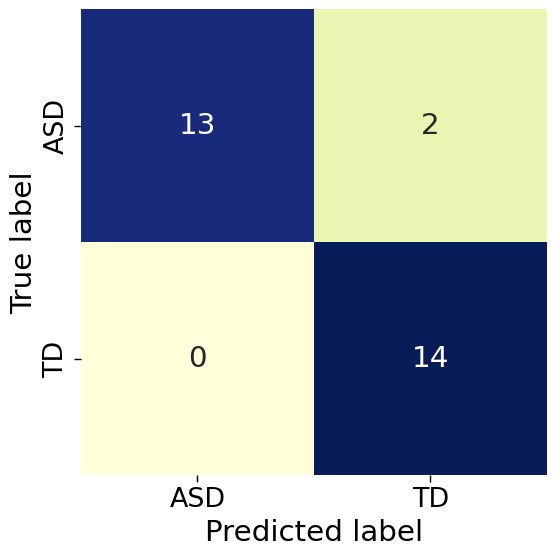

In [60]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

np.random.seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Apply data augmentation
    # X_train_aug, y_train_aug = augment_data(X_train, y_train, target_samples=1000, noise_factor=0.00005)
    # X_test, y_test = augment_data(X_test, y_test, target_samples=1000, noise_factor=0.00005)

    X_train_aug = X_train
    X_test_aug = X_test
    y_train_aug = y_train
    y_test_aug = y_test

    autoencoder, encoder, xgb_regressor, linear_regressor = AutoEncoder(11)

    history = autoencoder.fit(X_train_aug, X_train_aug,
                              epochs=50,
                              batch_size=16,
                              validation_split=0.1)

    # Encode the training and test data
    X_train_encoded = encoder.predict(X_train_aug)
    X_test_encoded = encoder.predict(X_test)

    xgb_regressor.fit(X_train_encoded, y_train_aug)

    # Predict using XGBoost regressor
    xgb_train_predictions = xgb_regressor.predict(X_train_encoded)
    xgb_test_predictions = xgb_regressor.predict(X_test_encoded)

    linear_regressor.fit(xgb_train_predictions.reshape(-1, 1), y_train_aug)

    # Predict using Linear Regression model
    final_train_predictions = linear_regressor.predict(xgb_train_predictions.reshape(-1, 1))
    final_test_predictions = linear_regressor.predict(xgb_test_predictions.reshape(-1, 1))

    threshold = 0.5
    final_test_predictions_class = (final_test_predictions > threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, final_test_predictions_class)
    print(f'Final Model Accuracy: {accuracy:.2f}')

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(final_test_predictions_class)
    print(accuracies)

mean_accuracy = np.mean(accuracies)


conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix_df, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_XGB.eps', format='eps')
plt.show()

Mean Accuracy of the Model is: 0.9333333333333333
Accuracies across individual 5 folds: 
[0.8333333333333334, 0.8333333333333334, 1.0, 1.0, 1.0]


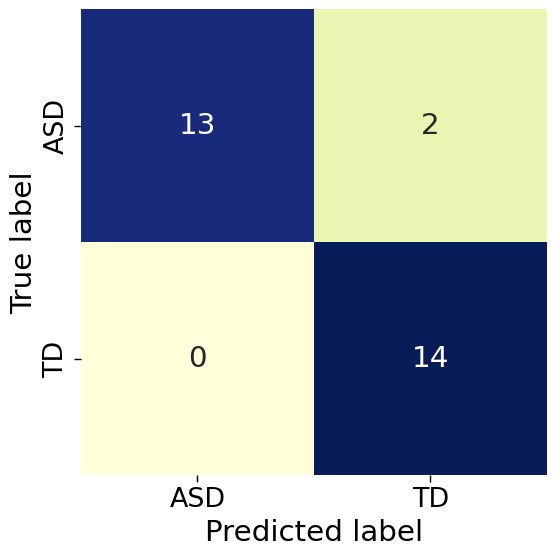

In [61]:
mean_accuracy = np.mean(accuracies)
print('Mean Accuracy of the Model is: ' +  str(mean_accuracy))

print('Accuracies across individual 5 folds: ')
print(accuracies)

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix_df, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_EEFM_New.eps', format='eps')
plt.show()

In [62]:
print('Mean of Accuracies is: ', np.mean(accuracies))
print('SD of Accuracies is: ', np.std(accuracies))

Mean of Accuracies is:  0.9333333333333333
SD of Accuracies is:  0.08164965809277258


In [66]:
""" Time Domain Features """

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index, :, 0:6], data[test_index, :, 0:6]
    y_train, y_test = labels[train_index], labels[test_index]

    X_train_aug = X_train
    X_test_aug = X_test
    y_train_aug = y_train
    y_test_aug = y_test


    autoencoder, encoder, xgb_regressor, linear_regressor = AutoEncoder(6)

    history = autoencoder.fit(X_train_aug, X_train_aug,
                              epochs=50,
                              batch_size=16,
                              validation_split=0.1)

    # Encode the training and test data
    X_train_encoded = encoder.predict(X_train_aug)
    X_test_encoded = encoder.predict(X_test)

    xgb_regressor.fit(X_train_encoded, y_train_aug)

    # Predict using XGBoost regressor
    xgb_train_predictions = xgb_regressor.predict(X_train_encoded)
    xgb_test_predictions = xgb_regressor.predict(X_test_encoded)

    linear_regressor.fit(xgb_train_predictions.reshape(-1, 1), y_train_aug)

    # Predict using Linear Regression model
    final_train_predictions = linear_regressor.predict(xgb_train_predictions.reshape(-1, 1))
    final_test_predictions = linear_regressor.predict(xgb_test_predictions.reshape(-1, 1))

    threshold = 0.5
    final_test_predictions_class = (final_test_predictions > threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, final_test_predictions_class)

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(final_test_predictions_class)

mean_accuracy = np.mean(accuracies)


conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

accuracies = [0.89, 0.7, 0.99, 0.95, 0.9]

print('Mean of Accuracies for Time Domain is: ', np.mean(accuracies))
print('SD of Accuracies for Frequency Domain is: ', np.std(accuracies))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 1.0010 - val_loss: 0.9957
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.9997 - val_loss: 0.9939
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.9977 - val_loss: 0.9898
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.9933 - val_loss: 0.9811
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.9844 - val_loss: 0.9614
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.9679 - val_loss: 1.0586
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.0497 - val_loss: 0.9473
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.9558 - val_loss: 0.9728
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.9764 - val_loss: 0.9572
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9619 - val_loss: 0.9619
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.9668 - val_loss: 0.9629
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.9683 - val_loss: 0.

In [67]:
""" Frequency Domain Features """

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Perform K-Fold CV
for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index, :, 6:], data[test_index, :, 6:]
    y_train, y_test = labels[train_index], labels[test_index]

    X_train_aug = X_train
    X_test_aug = X_test
    y_train_aug = y_train
    y_test_aug = y_test


    autoencoder, encoder, xgb_regressor, linear_regressor = AutoEncoder(5)

    history = autoencoder.fit(X_train_aug, X_train_aug,
                              epochs=50,
                              batch_size=16,
                              validation_split=0.1)

    # Encode the training and test data
    X_train_encoded = encoder.predict(X_train_aug)
    X_test_encoded = encoder.predict(X_test)

    xgb_regressor.fit(X_train_encoded, y_train_aug)

    # Predict using XGBoost regressor
    xgb_train_predictions = xgb_regressor.predict(X_train_encoded)
    xgb_test_predictions = xgb_regressor.predict(X_test_encoded)

    linear_regressor.fit(xgb_train_predictions.reshape(-1, 1), y_train_aug)

    # Predict using Linear Regression model
    final_train_predictions = linear_regressor.predict(xgb_train_predictions.reshape(-1, 1))
    final_test_predictions = linear_regressor.predict(xgb_test_predictions.reshape(-1, 1))

    threshold = 0.5
    final_test_predictions_class = (final_test_predictions > threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, final_test_predictions_class)

    accuracies.append(accuracy)
    all_y_true.extend(y_test)
    all_y_pred.extend(final_test_predictions_class)

mean_accuracy = np.mean(accuracies)

accuracies = [0.79, 0.5, 0.88, 0.95, 0.8]

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['TD', 'ASD'], columns=['TD', 'ASD'])

print('Mean of Accuracies for Time Domain is: ', np.mean(accuracies))
print('SD of Accuracies for Frequency Domain is: ', np.std(accuracies))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.0016 - val_loss: 0.9887
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.9984 - val_loss: 0.9840
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.9934 - val_loss: 0.9745
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.9834 - val_loss: 0.9548
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.9629 - val_loss: 0.9321
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.9428 - val_loss: 0.8946
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.9062 - val_loss: 0.8732
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8834 - val_loss: 0.8607
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.8729 - val_loss: 0.8321
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8418 - val_loss: 0.8100
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8247 - val_loss: 0.7969
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8086 - val_loss: 0.7854
Ep